# Lab 04 - Bayesian Fitting
## Tasks
- Construct a Gaussian Process model and tune hyperparameters of GP model given noisy data
- Investigate what kernels can be used to best represent the data

# Set up environment

In [1]:
!pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

In [2]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

import torch
import gpytorch

## Import Data
We are going to look at some data that was generated by sampling a 5 x 5 x 5 grid in the domain [0,1] on each axis. The function that generated this data is

$$
f(x_1,x_2,x_3) = \sin(2\pi x_1)\sin(\pi x_2) + x_3
$$

The columns of the imported array is $(x_1,x_2,x_3,f)$. We need to convert it to a torch tensor to use with GPyTorch.

In [4]:
x = np.linspace(0,1,5)
xx = np.meshgrid(x,x,x)
train_x = np.vstack([ele.ravel() for ele in xx]).T
train_f = np.sin(2*np.pi*train_x[:,0]) * np.sin(np.pi*train_x[:,1]) + train_x[:,2] + np.random.randn(train_x.shape[0]) * 0.01

train_x = torch.from_numpy(train_x)
train_f = torch.from_numpy(train_f)

## Define a GP Model
Here we define an Exact GP model using GPyTorch. The model is exact because we have analytic expressions for the integrals associated with the GP likelihood and output distribution. If we had a non-Gaussian likelihood or some other complication that prevented analytic integration we can also use Variational/Approximate/MCMC techniques to approximate the integrals necessary.

Taking a close look at the model below we see two important modules:
- ```self.mean_module``` which represents the mean function
- ```self.covar_module``` which represents the kernel function (or what is used to calculate the kernel matrix

Both of these objects are torch.nn.Module objects (see https://pytorch.org/docs/stable/generated/torch.nn.Module.html). PyTorch modules have trainable parameters which we can access when doing training. By grouping the modules inside another PyTorch module (gpytorch.models.ExactGP) lets us easily control which parameters are trained and which are not. 

In [5]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_f, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_f, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

Here we initialize our model with the training data and a defined likelihood (also a nn.Module) with a trainable noise parameter.

In [6]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_f, likelihood)

NOTE: All PyTorch modules (including ExactGPModel) have ```.train()``` and ```.eval()``` modes. ```train()``` mode is for optimizing model hyperameters. ```.eval()``` mode is for computing predictions through the model posterior.

## Training the model
Here we train the hyperparameters of the model (the parameters of the covar_module and the mean_module) to maximize the marginal log likelihood (minimize the negative marginal log likelihood). Note that since everything is defined in pyTorch we can use Autograd functionality to get the derivatives which will speed up optimization using the modified gradient descent algorithm ADAM.

Also note that several of these hyperparameters (lengthscale and noise) must be strictly positive. Since ADAM is an unconstrained optimizer (which optimizes over the domain (-inf, inf)) gpytorch accounts for this constraint by optimizing the log of the lengthscale (raw_lengthscale). To get the actual lengthscale just use ```model.covar_module.base_kernel.lengthscale.item()```

<div class="alert alert-block alert-info">
    
**Task:** 
    Write the steps for minimizing the negative log likelihood using pytorch. Refer back to Lab 3 for a reminder of how to do this. Use `gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)` as the loss function (which we are trying to maximize!). Use your function to train the model and report the marginal log likelihood.
    
</div>

In [7]:
def train_model(model, likelihood):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    

    for i in range(training_iter):
        pass


    #print the new trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')

    return loss

In [8]:
nmll = train_model(model, likelihood)

likelihood.noise_covar.raw_noise : Parameter containing:
tensor([0.], requires_grad=True)
mean_module.constant : Parameter containing:
tensor([0.], requires_grad=True)
covar_module.raw_outputscale : 0.0
covar_module.base_kernel.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)
Iter 1/100 - Loss: 0.925  noise: 0.693
Iter 2/100 - Loss: 0.891  noise: 0.644
Iter 3/100 - Loss: 0.858  noise: 0.598
Iter 4/100 - Loss: 0.826  noise: 0.554
Iter 5/100 - Loss: 0.796  noise: 0.513
Iter 6/100 - Loss: 0.766  noise: 0.474
Iter 7/100 - Loss: 0.738  noise: 0.438
Iter 8/100 - Loss: 0.711  noise: 0.403
Iter 9/100 - Loss: 0.685  noise: 0.372
Iter 10/100 - Loss: 0.661  noise: 0.342
Iter 11/100 - Loss: 0.639  noise: 0.314
Iter 12/100 - Loss: 0.619  noise: 0.289
Iter 13/100 - Loss: 0.600  noise: 0.265
Iter 14/100 - Loss: 0.583  noise: 0.244
Iter 15/100 - Loss: 0.568  noise: 0.224
Iter 16/100 - Loss: 0.556  noise: 0.207
Iter 17/100 - Loss: 0.545  noise: 0.191
Iter 18/100 - Loss: 0.537 

<div class="alert alert-block alert-info">

**Task:** 
    Define a new GP model that uses a different kernel (or combination of kernels) to maximize the marginal log likelihood.
    
</div>

In [9]:
class MyExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_f, likelihood):
        super(MyExactGPModel, self).__init__(train_x, train_f, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        
                                                        
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood.noise_covar.raw_noise : Parameter containing:
tensor([0.], requires_grad=True)
mean_module.constant : Parameter containing:
tensor([0.], requires_grad=True)
covar_module.raw_outputscale : 0.0
covar_module.base_kernel.kernels.0.kernels.0.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.base_kernel.kernels.0.kernels.0.raw_period_length : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.base_kernel.kernels.0.kernels.1.raw_lengthscale : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.base_kernel.kernels.0.kernels.1.raw_period_length : Parameter containing:
tensor([[0.]], requires_grad=True)
covar_module.base_kernel.kernels.1.raw_variance : Parameter containing:
tensor([[0.]], requires_grad=True)
Iter 1/100 - Loss: 0.930  noise: 0.693


/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 2/100 - Loss: 0.892  noise: 0.644
Iter 3/100 - Loss: 0.861  noise: 0.598
Iter 4/100 - Loss: 0.821  noise: 0.555
Iter 5/100 - Loss: 0.782  noise: 0.513
Iter 6/100 - Loss: 0.743  noise: 0.474
Iter 7/100 - Loss: 0.701  noise: 0.437
Iter 8/100 - Loss: 0.653  noise: 0.403
Iter 9/100 - Loss: 0.612  noise: 0.370
Iter 10/100 - Loss: 0.575  noise: 0.340
Iter 11/100 - Loss: 0.533  noise: 0.311
Iter 12/100 - Loss: 0.488  noise: 0.285
Iter 13/100 - Loss: 0.441  noise: 0.261
Iter 14/100 - Loss: 0.393  noise: 0.238
Iter 15/100 - Loss: 0.347  noise: 0.217
Iter 16/100 - Loss: 0.302  noise: 0.198
Iter 17/100 - Loss: 0.263  noise: 0.180
Iter 18/100 - Loss: 0.224  noise: 0.163
Iter 19/100 - Loss: 0.181  noise: 0.148
Iter 20/100 - Loss: 0.136  noise: 0.134
Iter 21/100 - Loss: 0.092  noise: 0.122
Iter 22/100 - Loss: 0.052  noise: 0.110
Iter 23/100 - Loss: 0.010  noise: 0.100
Iter 24/100 - Loss: -0.034  noise: 0.090
Iter 25/100 - Loss: -0.080  noise: 0.082
Iter 26/100 - Loss: -0.125  noise: 0.074
Iter 

tensor(-2.3266, dtype=torch.float64, grad_fn=<NegBackward>)

<div class="alert alert-block alert-info">

**Task:** 
    Plot the mean and uncertainty along the $x_1$ axis where $x_2=\pi/2, x_3=0$.
    
</div>

In [11]:
#Hint: you can use the following code to get the predicted mean, lower + upper confidence bounds
x = torch.zeros(1,3).double()
my_likelihood.eval()
my_model.eval()
with torch.no_grad():
    post = my_likelihood(my_model(x))
    mean = post.mean
    lower,upper = post.confidence_region()

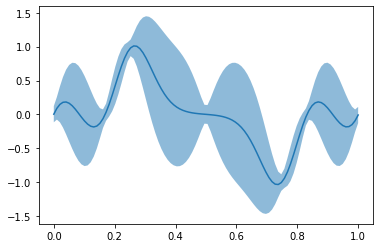